In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults, ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

/home/nicole/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from timeseries_functions import index_to_datetime, plot_all_df_columns, weekly_resample, plot_series,\
plot_series_save_fig, plot_series_and_differences, run_augmented_Dickey_Fuller_test, \
plot_autocorrelation, plot_partial_autocorrelation, plot_decomposition

In [3]:
from timeseries_functions import make_col_vector, make_design_matrix, fit_linear_trend,\
plot_trend_data, plot_linear_trend

In [4]:
from AR_MA_functions import get_AR_model, plot_AR_model, get_AR_model_order_BIC,\
plot_BIC_AR_model, get_MA_model, plot_MA_model

In [5]:
from ARIMA_functions import get_ARIMA_model, plot_ARIMA_model, plot_ARIMA_resids,\
get_ARIMA_forecast, plot_ARIMA_forecast_and_CI, plot_data_plus_ARIMA_predictions, \
test_rolling_ARIMA_forecast,get_predictions_df_and_plot_rolling_ARIMA_forecast

In [6]:
from ARIMA_functions import get_ARIMAX_model, plot_ARIMAX_model, plot_ARIMAX_model_save_fig, \
plot_data_plus_ARIMAX_predictions, get_ARIMAX_predictions, get_ARIMAX_training_MSE,\
get_ARIMAX_train_test_predictions, get_ARIMAX_train_test_MSE

#### import data

In [7]:
# import weekly hours and numbers data
dr = pd.read_csv('./data/doctors_hours_per_provider.csv', index_col=0)
RNPA = pd.read_csv('./data/RNPA_hours_per_provider.csv',  index_col=0)
therapist = pd.read_csv('./data/therapists_hours_per_provider.csv',  index_col=0)

In [8]:
# number of providers
num_dr = dr['Number_Providers']
num_RNPA = RNPA['Number_Providers']
num_therapist = therapist['Number_Providers']

In [9]:
# provider hours
dr_hours = dr['Hours']
RNPA_hours = RNPA['Hours']
therapist_hours = therapist['Hours']

In [10]:
providers = [num_dr, num_RNPA, num_therapist]
hours = [dr_hours, RNPA_hours, therapist_hours]

In [11]:
# dr_hours.index
num_dr.index

Index(['2015-01-12', '2015-01-19', '2015-01-26', '2015-02-02', '2015-02-09',
       '2015-02-16', '2015-02-23', '2015-03-02', '2015-03-09', '2015-03-16',
       ...
       '2018-02-26', '2018-03-05', '2018-03-12', '2018-03-19', '2018-03-26',
       '2018-04-02', '2018-04-09', '2018-04-16', '2018-04-23', '2018-04-30'],
      dtype='object', name='AppointmentDate', length=173)

#### convert index to datetime 

In [12]:
for p in providers:
    p.index = pd.to_datetime(p.index)
for h in hours:
    h.index = pd.to_datetime(h.index)

In [13]:
dr_hours.head()

AppointmentDate
2015-01-12    84.25
2015-01-19    91.25
2015-01-26    82.00
2015-02-02    72.25
2015-02-09    97.25
Name: Hours, dtype: float64

In [14]:
# label each series for labeling plots
num_dr.name = 'Number of Doctors'
num_RNPA.name = 'Number of RN/PAs'
num_therapist.name = 'Number of Therapists'

In [15]:
dr_hours.name = 'Doctors Hours'
RNPA_hours.name = 'RN/PAs Hours'
therapist_hours.name = 'Therapists Hours'

#### test for stationarity in all time series

In [16]:
providers = [num_dr, num_RNPA, num_therapist]
hours = [dr_hours, RNPA_hours, therapist_hours]

In [17]:
for p in providers:  
    print(p.name)
    run_augmented_Dickey_Fuller_test(series=p, num_diffs=2)

Number of Doctors
ADF Statistic: -0.22210617686559714
Critical values:
1%: -3.4698858990744115
5%: -2.8789026251889647
10%: -2.5760266680839004
The p-value for the series is: 0.935834808802605
ADF Statistic: -10.062709665196218
Critical values:
1%: -3.4698858990744115
5%: -2.8789026251889647
10%: -2.5760266680839004
The p-value for difference 1 is: 1.3205934622804431e-17
ADF Statistic: -6.432226640445463
Critical values:
1%: -3.471118535474365
5%: -2.8794405060097024
10%: -2.576313761526591
The p-value for difference 2 is: 1.686328384757272e-08
Number of RN/PAs
ADF Statistic: -0.2858218164455114
Critical values:
1%: -3.469648263987657
5%: -2.878798906308495
10%: -2.5759713094779593
The p-value for the series is: 0.9274885217885349
ADF Statistic: -11.372131563286946
Critical values:
1%: -3.469648263987657
5%: -2.878798906308495
10%: -2.5759713094779593
The p-value for difference 1 is: 8.925784342155933e-21
ADF Statistic: -4.328790542467453
Critical values:
1%: -3.472161410886292
5%: -2.

In [18]:
for h in hours:
    print(h.name)
    run_augmented_Dickey_Fuller_test(series=h, num_diffs=2)

Doctors Hours
ADF Statistic: -0.7577330097905544
Critical values:
1%: -3.4698858990744115
5%: -2.8789026251889647
10%: -2.5760266680839004
The p-value for the series is: 0.8312235926317735
ADF Statistic: -13.032794678072865
Critical values:
1%: -3.4698858990744115
5%: -2.8789026251889647
10%: -2.5760266680839004
The p-value for difference 1 is: 2.3261760845392414e-24
ADF Statistic: -4.936782287119396
Critical values:
1%: -3.4729792729247793
5%: -2.8802520918255534
10%: -2.5767469641683105
The p-value for difference 2 is: 2.955880847496221e-05
RN/PAs Hours
ADF Statistic: -1.3334919589536902
Critical values:
1%: -3.470126426071447
5%: -2.8790075987120027
10%: -2.5760826967621644
The p-value for the series is: 0.6137138660917639
ADF Statistic: -9.423667716324665
Critical values:
1%: -3.470126426071447
5%: -2.8790075987120027
10%: -2.5760826967621644
The p-value for difference 1 is: 5.418320862866177e-16
ADF Statistic: -5.761340950482132
Critical values:
1%: -3.47086589632514
5%: -2.879330

In [19]:
providers[0].diff().isnull().sum()

1

#### determine number of AR and MA terms to add for each time series

In [20]:
hours[2].isnull().sum()

0

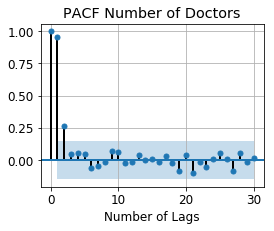

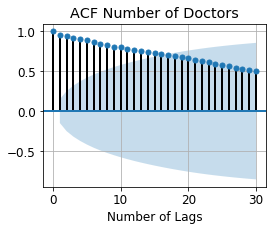

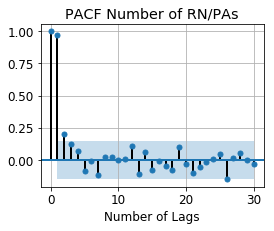

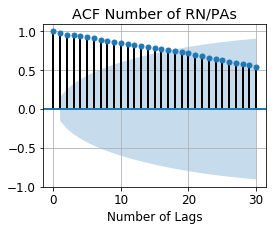

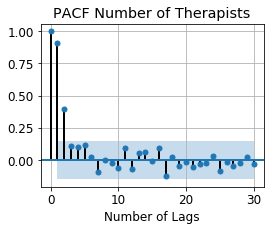

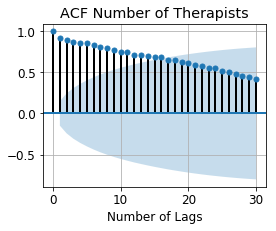

In [21]:
# Plot ACF and PACF of each series
for p in providers:
    params = {'figure.figsize': [4,3],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
    plot_partial_autocorrelation(series=p, params=params, lags=30, alpha=0.05, title='PACF {}'.format(p.name))
    plot_autocorrelation(series=p, params=params, lags=30, alpha=0.05, title='ACF {}'.format(p.name))

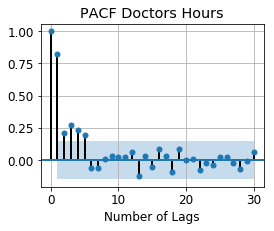

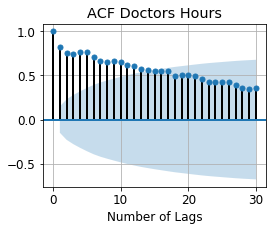

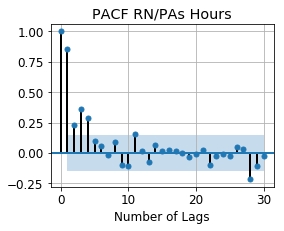

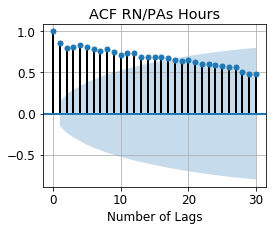

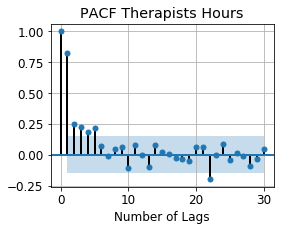

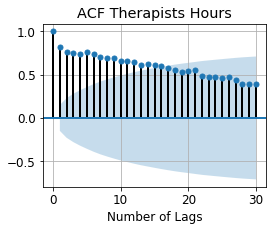

In [22]:
# Plot ACF and PACF of each series
for h in hours:
    params = {'figure.figsize': [4,3],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
    plot_partial_autocorrelation(series=h, params=params, lags=30, alpha=0.05, title='PACF {}'.format(h.name))
    plot_autocorrelation(series=h, params=params, lags=30, alpha=0.05, title='ACF {}'.format(h.name))

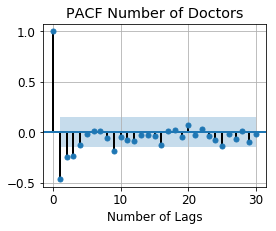

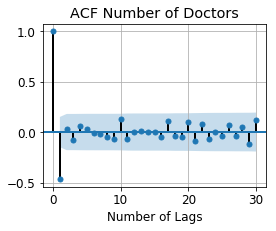

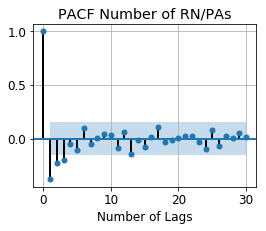

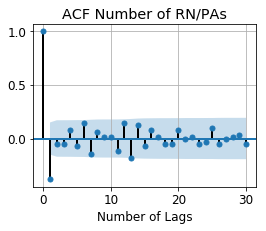

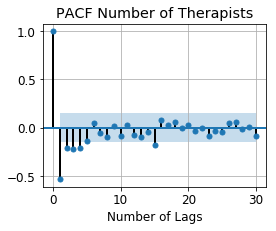

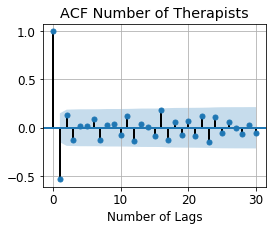

In [23]:
# Plot ACF and PACF of first difference of each series
for p in providers:
    params = {'figure.figsize': [4,3],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
    plot_partial_autocorrelation(series=p.diff()[1:], params=params, lags=30, alpha=0.05, title='PACF {}'.format(p.name))
    plot_autocorrelation(series=p.diff()[1:], params=params, lags=30, alpha=0.05, title='ACF {}'.format(p.name))

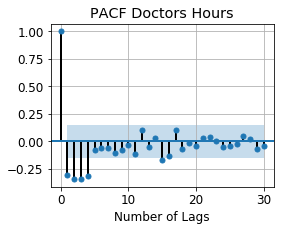

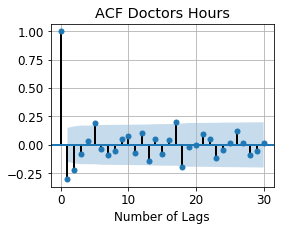

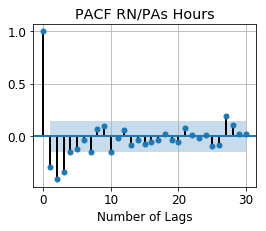

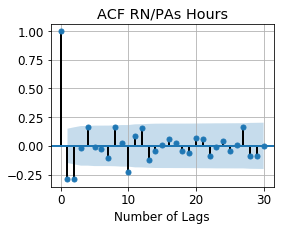

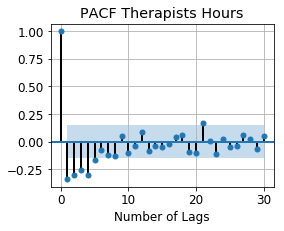

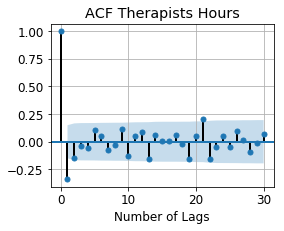

In [24]:
# Plot ACF and PACF of first difference of each series
for h in hours:
    params = {'figure.figsize': [4,3],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
    plot_partial_autocorrelation(series=h.diff()[1:], params=params, lags=30, alpha=0.05, title='PACF {}'.format(h.name))
    plot_autocorrelation(series=h.diff()[1:], params=params, lags=30, alpha=0.05, title='ACF {}'.format(h.name))

#### get ARIMAX model using num_provider as exogenous variable and plot

In [25]:
def get_ARIMAX_model(data, order, exog_var):
    """Fits ARIMAX model
    data: pandas Series
    order: (p,d,q) format
    exog_var = exogenous variable as pandas Series
    """
    arima = ARIMA(endog=data, order=order, exog=exog_var)
    results = arima.fit()
    summary = results.summary()
    params = results.params
    residuals = results.resid
    return results, summary, params, residuals

#### split data into training and test sets

In [26]:
train_start = '2015-01-12'
train_end = '2018-03-01'
test_start = '2018-03-01'

In [27]:
dr_train = dr.loc[train_start:train_end]
dr_test = dr.loc[test_start:]

In [28]:
# dr_train.tail()
dr_test.tail()

,Number_Providers,Hours,Hours_per_Provider
AppointmentDate,,,
2018-04-02,16.0,313.250000,19.578125
2018-04-09,17.0,332.916667,19.583333
2018-04-16,17.0,284.750000,16.750000
2018-04-23,17.0,297.833333,17.519608
2018-04-30,16.0,299.416667,18.713542


In [29]:
RNPA_train = RNPA.loc[train_start:train_end]
RNPA_test = RNPA.loc[test_start:]

In [30]:
ther_train = therapist.loc[train_start:train_end]
ther_test = therapist.loc[test_start:]

#### get MSE (train and test data) for each category, testing # of MA components to compare models

In [31]:
# dr AR(4)MA(1)
# RN/PA AR(3)MA(2)
# ther AR(5)MA(1)

In [32]:
train_dfs = [dr_train, RNPA_train, ther_train]
test_dfs = [dr_test, RNPA_test, ther_test]
orders = [(4,1,1), (3,1,2), (5,1,1)]
endog_col = 'Hours'
exog_col = 'Number_Providers'
names = ['Doctors', 'RN/PAs', 'Therapists']
test_start='2018-03-05'
train_start = '2015-01-12'
train_end = '2018-02-26'

In [33]:
# get train/test predictions and MSE for all 3 categories 
train_mse = []
test_mse = []
category = []

for i in range(len(train_dfs)):
    forecast, full_df = get_ARIMAX_train_test_predictions(training_data=train_dfs[i][endog_col],\
            test_data=test_dfs[i][endog_col], order=orders[i], start='2015-01-19',\
            end='2018-04-30', exog=train_dfs[i][exog_col], typ='levels')
    train_error, test_error = get_ARIMAX_train_test_MSE(full_df, data_col='data', pred_col='forecast',\
                        train_end='2018-02-26', test_start='2018-03-05', data_name=names[i])   
    train_mse.append('training set: {}'.format(train_error))
    test_mse.append('test set: {}'.format(test_error))
    category.append('{} MSE'.format(names[i]))
mse = zip(train_mse, test_mse)
print(list(zip(category,mse)))

[('Doctors MSE', ('training set: 1005.8112231830528', 'test set: 784.6751134118571')), ('RN/PAs MSE', ('training set: 149.71532917537328', 'test set: 194.1696355084507')), ('Therapists MSE', ('training set: 105.80806435978357', 'test set: 35.63718570403454'))]


#### Doctors

In [34]:
# dr AR(4)MA(1)
# RN/PA AR(3)MA(2)
# ther AR(5)MA(1)

In [35]:
start_date = '2015-01-19' # b/c first row of data was differenced away
end_date = '2018-04-30'
end_pred = '2018-09-30'

In [36]:
dr_results, dr_summary, dr_params, dr_residuals = get_ARIMAX_model(data=dr_hours,\
                    exog_var=num_dr, order=(4,1,1))

In [37]:
num_dr

AppointmentDate
2015-01-12     4.0
2015-01-19     3.0
2015-01-26     3.0
2015-02-02     3.0
2015-02-09     5.0
2015-02-16     4.0
2015-02-23     4.0
2015-03-02     4.0
2015-03-09     5.0
2015-03-16     4.0
2015-03-23     5.0
2015-03-30     4.0
2015-04-06     5.0
2015-04-13     5.0
2015-04-20     5.0
2015-04-27     5.0
2015-05-04     5.0
2015-05-11     4.0
2015-05-18     5.0
2015-05-25     5.0
2015-06-01     5.0
2015-06-08     5.0
2015-06-15     4.0
2015-06-22     5.0
2015-06-29     5.0
2015-07-06     5.0
2015-07-13     5.0
2015-07-20     5.0
2015-07-27     5.0
2015-08-03     5.0
              ... 
2017-10-09    15.0
2017-10-16    14.0
2017-10-23    14.0
2017-10-30    16.0
2017-11-06    16.0
2017-11-13    14.0
2017-11-20    16.0
2017-11-27    15.0
2017-12-04    16.0
2017-12-11    16.0
2017-12-18    14.0
2017-12-25    16.0
2018-01-01    12.0
2018-01-08    15.0
2018-01-15    15.0
2018-01-22    14.0
2018-01-29    15.0
2018-02-05    15.0
2018-02-12    16.0
2018-02-19    15.0
2018-02-26    1

In [38]:
def plot_ARIMAX_model_save_fig(data, order, exog_var, start, end, title='', xlabel='', ylabel='',
                              figname='figure.png'):
    """Plots ARIMAX model
    data: pandas Series
    order: (p,d,q) format
    exog_var = exogenous variable as pandas Series
    start/end: starting/ending dates for plot (x_axis)
    """
    results = ARIMA(endog=data, order=order, exog=exog_var).fit()
    fig = results.plot_predict(start=start, end=end,exog=exog_var)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    fig.savefig(figname)

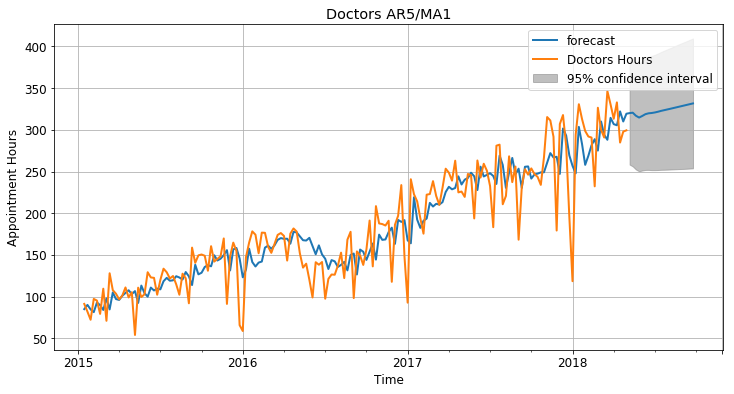

In [93]:
# plot and save doctors figure using 4 AR components 1 MA component
params = {'figure.figsize': [12,6],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)

plot_ARIMAX_model_save_fig(data=dr_hours, order=(4,1,1), exog_var=num_dr, start=start_date,\
                end=end_pred, title='Doctors AR5/MA1', xlabel='Time', ylabel='Appointment Hours',
                              figname='./images/dr_AR[4]IMA[1]X.png')

In [40]:
def get_ARIMAX_predictions(data, order, start, end, exog=None, typ='levels'):
    """Get ARIMAX predictions
    Inputs:
        data: pandas Series
        order: (p,d,q) format
        start/end: (str) starting/ending dates
        exog: data for exogenous variable as pandas series
    Outputs:
        data_plus_forecast: dataframe with original data and forecast plot_all_df_columns
        forecast: just predictions
    """
    data = data.to_frame()
    results = ARIMA(data, order=order, exog=exog).fit()
    forecast = results.predict(start=start, end=end, exog=exog, typ=typ).to_frame()
    data_plus_forecast = pd.merge(left=data, right=forecast, how='outer', left_index=True, right_index=True)
    data_plus_forecast.columns = ['data', 'forecast']
    return forecast, data_plus_forecast

In [41]:
# getARIMAX predictions and data+predictions dataframe for doctors using order = (4,1,1)

start_date = '2015-01-19'
end_pred = '2018-09-30'
dr_forecast, dr_data_plus_forecast = get_ARIMAX_predictions(data=dr_hours, order=(4,1,1), start=start_date,\
                    end=end_pred, exog=num_dr, typ='levels')

In [42]:
dr_forecast

,0
2015-01-19,84.985930
2015-01-26,90.077476
2015-02-02,84.668197
2015-02-09,81.396030
2015-02-16,92.918006
2015-02-23,89.813383
2015-03-02,84.003251
2015-03-09,97.868537
2015-03-16,84.644116
2015-03-23,104.976498


In [43]:
dr_data_plus_forecast.columns

Index(['data', 'forecast'], dtype='object')

In [44]:
# rename columns in forecast df
dr_data_plus_forecast.columns = ['Appointment_Hours', 'Predicted_Hours']

In [45]:
dr_data_plus_forecast

,Appointment_Hours,Predicted_Hours
2015-01-12,84.250000,NaN
2015-01-19,91.250000,84.985930
2015-01-26,82.000000,90.077476
2015-02-02,72.250000,84.668197
2015-02-09,97.250000,81.396030
2015-02-16,95.250000,92.918006
2015-02-23,79.250000,89.813383
2015-03-02,109.500000,84.003251
2015-03-09,71.000000,97.868537
2015-03-16,128.000000,84.644116


In [46]:
# Round Appointment Hours and Predicted Hours values
dr_data_plus_forecast['Appointment_Hours'] = round(dr_data_plus_forecast['Appointment_Hours'], 2)
dr_data_plus_forecast['Predicted_Hours'] = round(dr_data_plus_forecast['Predicted_Hours'], 2)

In [47]:
# add number of providers column
dr_data_plus_forecast['Number_Providers'] = num_dr

In [48]:
# calculate hours per provider
dr_data_plus_forecast['Hours_per_Provider'] = round(dr_data_plus_forecast['Appointment_Hours'] / dr_data_plus_forecast['Number_Providers'],2)

In [49]:
# calculate predicted number of providers and hours/provider columns
dr_data_plus_forecast['Pred_Hours_per_Provider'] = round(dr_data_plus_forecast['Predicted_Hours']/dr_data_plus_forecast['Number_Providers'], 2)

In [50]:
dr_data_plus_forecast

,Appointment_Hours,Predicted_Hours,Number_Providers,Hours_per_Provider,Pred_Hours_per_Provider
2015-01-12,84.25,NaN,4.0,21.06,NaN
2015-01-19,91.25,84.99,3.0,30.42,28.33
2015-01-26,82.00,90.08,3.0,27.33,30.03
2015-02-02,72.25,84.67,3.0,24.08,28.22
2015-02-09,97.25,81.40,5.0,19.45,16.28
2015-02-16,95.25,92.92,4.0,23.81,23.23
2015-02-23,79.25,89.81,4.0,19.81,22.45
2015-03-02,109.50,84.00,4.0,27.38,21.00
2015-03-09,71.00,97.87,5.0,14.20,19.57
2015-03-16,128.00,84.64,4.0,32.00,21.16


In [51]:
avg_dr_hours = dr_data_plus_forecast['Hours_per_Provider'].mean()

In [52]:
avg_dr_hours

19.64236994219654

In [53]:
# get predicted number of providers, rounded 
dr_data_plus_forecast['Predicted_Num_Providers'] = round(dr_data_plus_forecast['Predicted_Hours'] / avg_dr_hours, 1)

In [54]:
dr_data_plus_forecast

,Appointment_Hours,Predicted_Hours,Number_Providers,Hours_per_Provider,Pred_Hours_per_Provider,Predicted_Num_Providers
2015-01-12,84.25,NaN,4.0,21.06,NaN,NaN
2015-01-19,91.25,84.99,3.0,30.42,28.33,4.3
2015-01-26,82.00,90.08,3.0,27.33,30.03,4.6
2015-02-02,72.25,84.67,3.0,24.08,28.22,4.3
2015-02-09,97.25,81.40,5.0,19.45,16.28,4.1
2015-02-16,95.25,92.92,4.0,23.81,23.23,4.7
2015-02-23,79.25,89.81,4.0,19.81,22.45,4.6
2015-03-02,109.50,84.00,4.0,27.38,21.00,4.3
2015-03-09,71.00,97.87,5.0,14.20,19.57,5.0
2015-03-16,128.00,84.64,4.0,32.00,21.16,4.3


In [55]:
# output full forecast dataframe to csv
dr_data_plus_forecast.to_csv('./data/dr_arimax_forecast.csv')

In [56]:
# get 12 week forecast
dr_12wk_arimax = dr_data_plus_forecast['2018-05-07':'2018-07-30'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
dr_12wk_arimax.index = dr_12wk_arimax.index.date

In [57]:
# get 8-16 week forecast
dr_8_to_16wk_arimax = dr_data_plus_forecast['2018-06-25':'2018-08-26'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
dr_8_to_16wk_arimax.index = dr_8_to_16wk_arimax.index.date

In [58]:
dr_8_to_16wk_arimax

,Predicted_Hours,Predicted_Num_Providers
2018-06-25,320.20,16.3
2018-07-02,320.86,16.3
2018-07-09,321.76,16.4
2018-07-16,322.79,16.4
2018-07-23,323.64,16.5
2018-07-30,324.51,16.5
2018-08-06,325.40,16.6
2018-08-13,326.31,16.6
2018-08-20,327.23,16.7


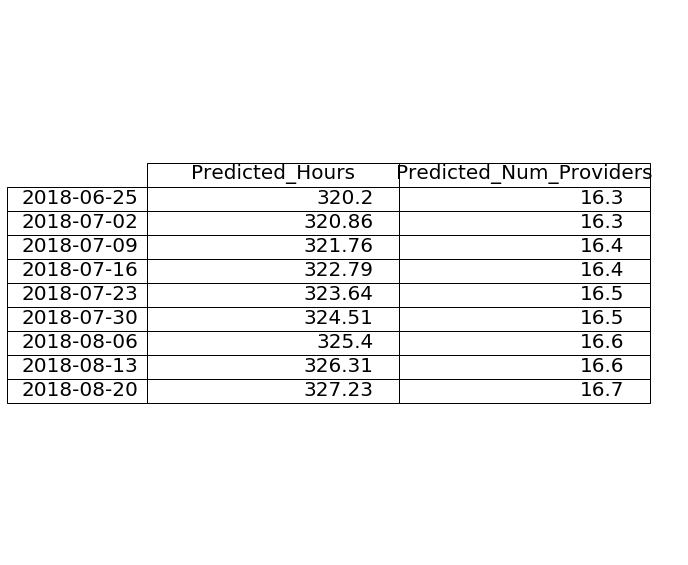

In [59]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, dr_8_to_16wk_arimax, loc='center', colWidths=[0.3]*len(dr_8_to_16wk_arimax.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(20)
tabla.scale(1.5, 2) 
plt.savefig('./images/dr_8_to_16wk_arimax.png', transparent=True)

In [60]:
dr_12wk_arimax

,Predicted_Hours,Predicted_Num_Providers
2018-05-07,320.07,16.3
2018-05-14,320.58,16.3
2018-05-21,316.90,16.1
2018-05-28,314.72,16.0
2018-06-04,316.65,16.1
2018-06-11,318.80,16.2
2018-06-18,319.83,16.3
2018-06-25,320.20,16.3
2018-07-02,320.86,16.3
2018-07-09,321.76,16.4


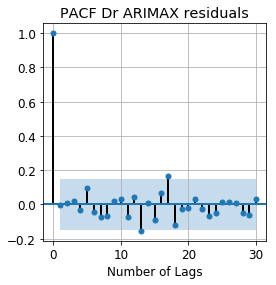

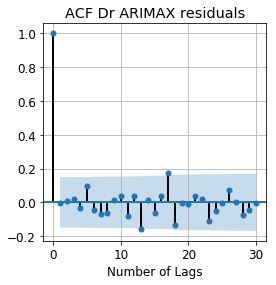

In [61]:
# plot acf/pacf of Dr ARIMAX residuals
params = {'figure.figsize': [4,4],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plot_partial_autocorrelation(series=dr_residuals, params=params, lags=30, alpha=0.05, title='PACF {}'.format('Dr ARIMAX residuals'))
plot_autocorrelation(series=dr_residuals, params=params, lags=30, alpha=0.05, title='ACF {}'.format('Dr ARIMAX residuals'))

#### RN/PAs

In [62]:
# dr AR(4)MA(1)
# RN/PA AR(3)MA(2)
# ther AR(5)MA(1)

In [63]:
start_date = '2015-01-19' # b/c first row was differenced away
end_date = '2018-04-30'
end_pred = '2018-09-30'
RNPA_order = (3,1,2)

In [64]:
RNPA_results, RNPA_summary, RNPA_params, RNPA_residuals = get_ARIMAX_model(data=dr_hours,\
                    exog_var=num_dr, order=RNPA_order)

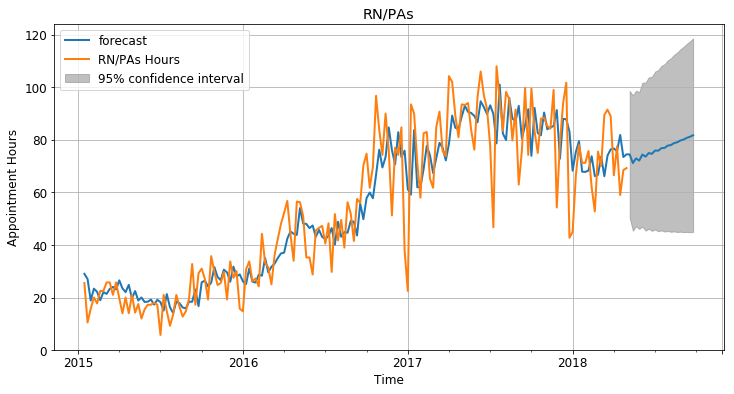

In [65]:
# plot and save RN/PA figure 
# using 3 AR components and 2 MA components
params = {'figure.figsize': [12,6],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)

plot_ARIMAX_model_save_fig(data=RNPA_hours, order=(3,1,2), exog_var=num_RNPA, start=start_date,\
                end=end_pred, title='RN/PAs', xlabel='Time', ylabel='Appointment Hours',
                              figname='./images/RNPA_AR[3]IMA[2]X.png')

In [66]:
# getARIMAX predictions and data+predictions dataframe for RN/PAs order=(3,1,2)
start_date = '2015-01-19'
end_pred = '2018-09-30'
RNPA_forecast, RNPA_data_plus_forecast = get_ARIMAX_predictions(data=RNPA_hours, order=(3,1,2), start=start_date,\
                    end=end_pred, exog=num_RNPA, typ='levels')

In [67]:
RNPA_forecast

,0
2015-01-19,29.009691
2015-01-26,27.039843
2015-02-02,18.868586
2015-02-09,23.373826
2015-02-16,22.194380
2015-02-23,18.973775
2015-03-02,22.053639
2015-03-09,21.365212
2015-03-16,23.296441
2015-03-23,24.058867


In [68]:
# rename columns in forecast df
RNPA_data_plus_forecast.columns = ['Appointment_Hours', 'Predicted_Hours']

# Round Predicted Hours values
RNPA_data_plus_forecast['Predicted_Hours'] = round(RNPA_data_plus_forecast['Predicted_Hours'], 2)

# add number of providers and hours/provider columns
RNPA_data_plus_forecast['Number_Providers'] = num_RNPA
RNPA_data_plus_forecast['Pred_Hours_per_Provider'] = round(RNPA_data_plus_forecast['Predicted_Hours']/RNPA_data_plus_forecast['Number_Providers'], 2)

In [69]:
avg_RNPA_hours = RNPA_data_plus_forecast['Pred_Hours_per_Provider'].mean()

In [70]:
avg_RNPA_hours

13.564534883720928

In [71]:
# get predicted number of providers rounded
RNPA_data_plus_forecast['Predicted_Num_Providers'] = round(RNPA_data_plus_forecast['Predicted_Hours'] / avg_RNPA_hours, 1)

In [72]:
RNPA_data_plus_forecast

,Appointment_Hours,Predicted_Hours,Number_Providers,Pred_Hours_per_Provider,Predicted_Num_Providers
2015-01-12,28.50,NaN,1.0,NaN,NaN
2015-01-19,25.50,29.01,1.0,29.01,2.1
2015-01-26,10.50,27.04,1.0,27.04,2.0
2015-02-02,15.75,18.87,1.0,18.87,1.4
2015-02-09,20.00,23.37,1.0,23.37,1.7
2015-02-16,17.75,22.19,1.0,22.19,1.6
2015-02-23,22.50,18.97,1.0,18.97,1.4
2015-03-02,22.50,22.05,1.0,22.05,1.6
2015-03-09,25.75,21.37,1.0,21.37,1.6
2015-03-16,25.75,23.30,1.0,23.30,1.7


In [73]:
# output full forecast dataframe to csv
RNPA_data_plus_forecast.to_csv('./data/RNPA_arimax_forecast.csv')

In [74]:
# get 12 week forecast
RNPA_12wk_arimax = RNPA_data_plus_forecast['2018-05-07':'2018-07-30'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
RNPA_12wk_arimax.index = RNPA_12wk_arimax.index.date

In [75]:
# get 8-16 week forecast
RNPA_8_to_16wk_arimax = RNPA_data_plus_forecast['2018-06-25':'2018-08-26'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
RNPA_8_to_16wk_arimax.index = RNPA_8_to_16wk_arimax.index.date

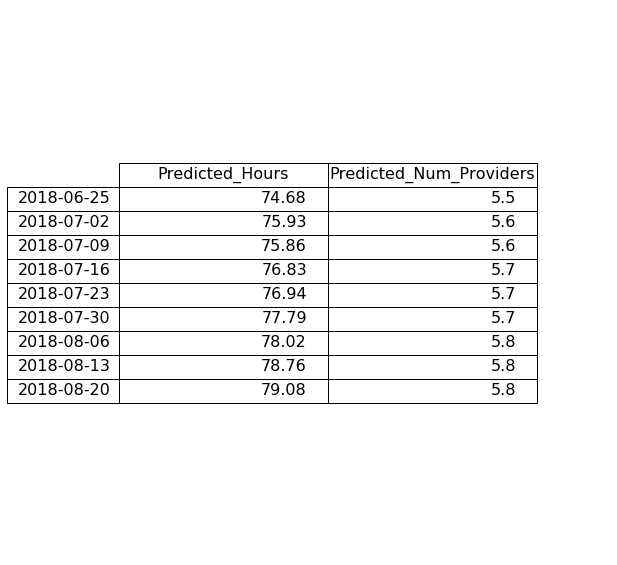

In [76]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, RNPA_8_to_16wk_arimax, loc='center', colWidths=[0.25]*len(RNPA_8_to_16wk_arimax.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(16)
tabla.scale(1.5, 2) 
plt.savefig('./images/RNPA_8_to_16wk_arimax.png', transparent=True)

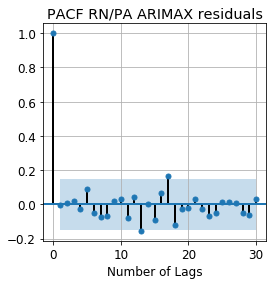

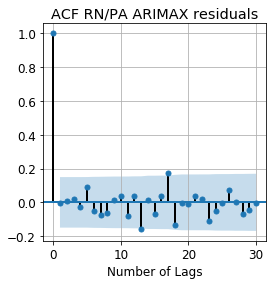

In [77]:
# plot acf/pacf of RN/PA ARIMAX residuals
params = {'figure.figsize': [4,4],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plot_partial_autocorrelation(series=RNPA_residuals, params=params, lags=30, alpha=0.05, title='PACF {}'.format('RN/PA ARIMAX residuals'))
plot_autocorrelation(series=RNPA_residuals, params=params, lags=30, alpha=0.05, title='ACF {}'.format('RN/PA ARIMAX residuals'))

#### therapists

In [78]:
# dr AR(4)MA(1)
# RN/PA AR(3)MA(2)
# ther AR(5)MA(1)

In [79]:
start_date = '2015-01-19' # b/c first row was differenced away 
end_date = '2018-04-30'
end_pred = '2018-09-30'
therapist_order = (5,1,1)

In [80]:
therapist_results, therapist_summary, therapist_params, therapist_residuals = get_ARIMAX_model(data=therapist_hours,\
                    exog_var=num_therapist, order=therapist_order)

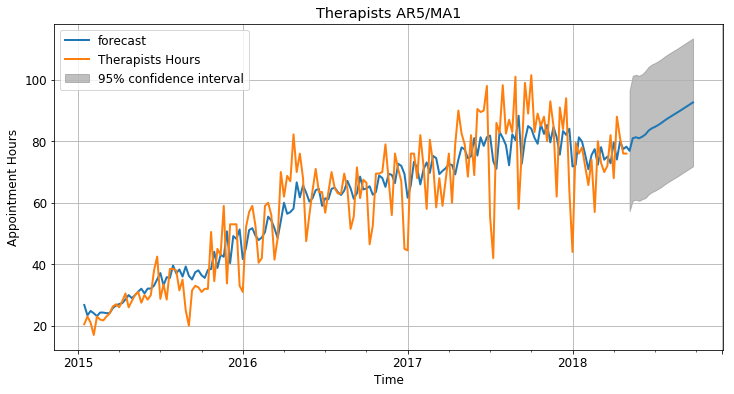

In [81]:
# plot and save therapist figure 
# using 5 AR components and 1 MA components
params = {'figure.figsize': [12,6],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)

plot_ARIMAX_model_save_fig(data=therapist_hours, order=(5,1,1), exog_var=num_therapist, start=start_date,\
                end=end_pred, title='Therapists AR5/MA1', xlabel='Time', ylabel='Appointment Hours',
                              figname='./images/therapist_AR[5]IMA[1]X.png')

In [82]:
# getARIMAX predictions and data+predictions dataframe for therapists
start_date = '2015-01-19'
end_pred = '2018-09-30'
ther_forecast, ther_data_plus_forecast = get_ARIMAX_predictions(data=therapist_hours, order=(5,1,1), start=start_date,\
                    end=end_pred, exog=num_therapist, typ='levels')

In [83]:
# rename columns in forecast df
ther_data_plus_forecast.columns = ['Appointment_Hours', 'Predicted_Hours']

# Round Predicted Hours values
ther_data_plus_forecast['Predicted_Hours'] = round(ther_data_plus_forecast['Predicted_Hours'], 2)

# add number of providers and hours/provider columns
ther_data_plus_forecast['Number_Providers'] = num_therapist
ther_data_plus_forecast['Pred_Hours_per_Provider'] = round(ther_data_plus_forecast['Predicted_Hours']/ther_data_plus_forecast['Number_Providers'], 1)

In [84]:
avg_ther_hours = ther_data_plus_forecast['Pred_Hours_per_Provider'].mean()

In [85]:
avg_ther_hours

11.312790697674414

In [86]:
# get predicted number of providers rounded up
ther_data_plus_forecast['Predicted_Num_Providers'] = round(ther_data_plus_forecast['Predicted_Hours'] / avg_ther_hours, 1)

In [87]:
ther_data_plus_forecast

,Appointment_Hours,Predicted_Hours,Number_Providers,Pred_Hours_per_Provider,Predicted_Num_Providers
2015-01-12,26.00,NaN,1.0,NaN,NaN
2015-01-19,20.50,26.74,1.0,26.7,2.4
2015-01-26,23.00,23.38,1.0,23.4,2.1
2015-02-02,21.00,24.82,1.0,24.8,2.2
2015-02-09,17.00,24.06,1.0,24.1,2.1
2015-02-16,23.00,23.12,2.0,11.6,2.0
2015-02-23,22.00,24.30,2.0,12.2,2.1
2015-03-02,21.75,24.29,2.0,12.1,2.1
2015-03-09,23.00,24.09,2.0,12.0,2.1
2015-03-16,24.00,24.10,2.0,12.0,2.1


In [88]:
# output full forecast dataframe to csv
ther_data_plus_forecast.to_csv('./data/therapist_arimax_forecast.csv')

In [89]:
# get 12 week forecast
ther_12wk_arimax = ther_data_plus_forecast['2018-05-07':'2018-07-30'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
ther_12wk_arimax.index = ther_12wk_arimax.index.date

In [90]:
# get 8-16 week forecast
ther_8_to_16wk_arimax = ther_data_plus_forecast['2018-06-25':'2018-08-26'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
ther_8_to_16wk_arimax.index = ther_8_to_16wk_arimax.index.date

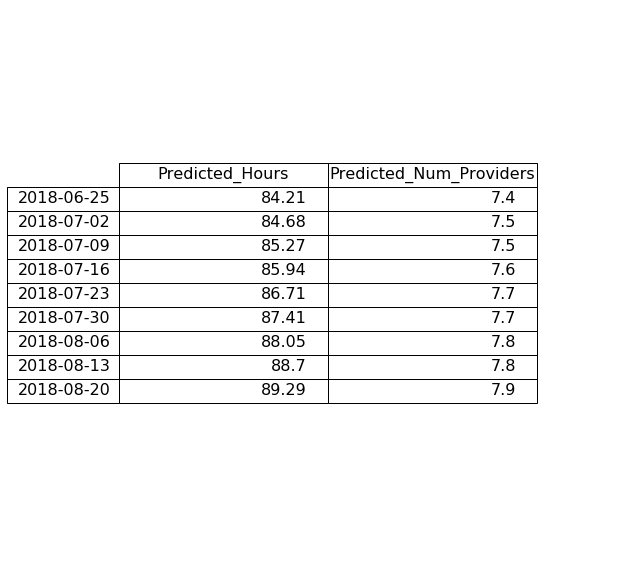

In [91]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, ther_8_to_16wk_arimax, loc='center', colWidths=[0.25]*len(ther_8_to_16wk_arimax.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(16)
tabla.scale(1.5, 2) 
plt.savefig('./images/ther_8_to_16wk_arimax.png', transparent=True)

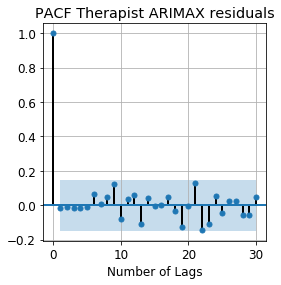

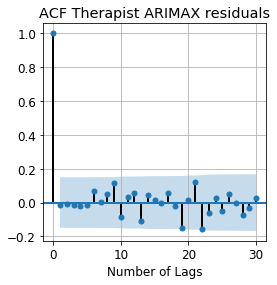

In [92]:
# plot acf/pacf of therapist ARIMAX residuals
params = {'figure.figsize': [4,4],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plot_partial_autocorrelation(series=therapist_residuals, params=params, lags=30, alpha=0.05, title='PACF {}'.format('Therapist ARIMAX residuals'))
plot_autocorrelation(series=therapist_residuals, params=params, lags=30, alpha=0.05, title='ACF {}'.format('Therapist ARIMAX residuals'))